# <center>Digital Holography - A141 - Mifobio 2023

Welcome to workshop A141 on digital holography for label free imaging of biological tissues! This notebook will give you a grasp on how interferometry is used to measure the electrical field, and how to process this field to recover an image.

For this notebook to work properly on your laptop, all you will need is:
- a working Python installation. Use Anaconda if you've never done it before.
- Jupyter notebook installed
- Numpy and Matplotlib installed.

### Import librairies

In [1]:
#%matplotlib notebook

import json
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from PIL import Image

from mifobio.utils import multi_slice_viewer

###  Download data

Click on [this link](https://filesender.renater.fr/?s=download&token=a2da1d1e-770f-4db5-9d7c-85c778751964) this link to download the json parameter file and the data (nmat=0), put both in the same directory, unzip it and fill below the path to the directory. For example:

```
$ tree
.
└── Desktop
    └── MifobioA141
        ├── 03-11-2023-mire-defoc.json
        └── n_mat=0
            └── Intensity00000000.tif
            ...
```

In [2]:
directory = Path("/Users/orbitalclover/Desktop/MifobioA141")
name = "Mire_focused_mifobio"
extension = ".json"
path_to_params = directory / (name + extension)
  
# Opening JSON file
f = open(path_to_params)
params = json.load(f)

# Size of the images
nx = params['nx']

# Numerical Aperture
na = params['na']

In [3]:
path_to_images = directory / "n_mat=0"

## 4-phase interferometry

We start by using 4-phase interferometry to measure the electrical field $E_s$ from measures of intensity:

$$
\begin{align}
I(\mathbf{r}, \delta) &= |E_s(\mathbf{r}) + E_r(\mathbf{r}) e^{-2i \frac{\pi}{\lambda}\delta}|^2 \\
              &= |E_s(\mathbf{r})|^2 + 1 + 2Re\left(E_s(\mathbf{r}) e^{2i \frac{\pi}{\lambda}\delta} \right)
\end{align}
$$

We measure the intensity for $\delta = -\lambda / 2, -\lambda / 4, 0, \lambda /4$. Let's first observe these four images.

In [4]:
images = []
illu = (params['n_uin'] - 1) // 2
for i in range(4):
    im = np.array(Image.open(path_to_images / f"Intensity{illu * 4 + i:08}.tif"))
    images.append(im.astype(np.float32) / 255)

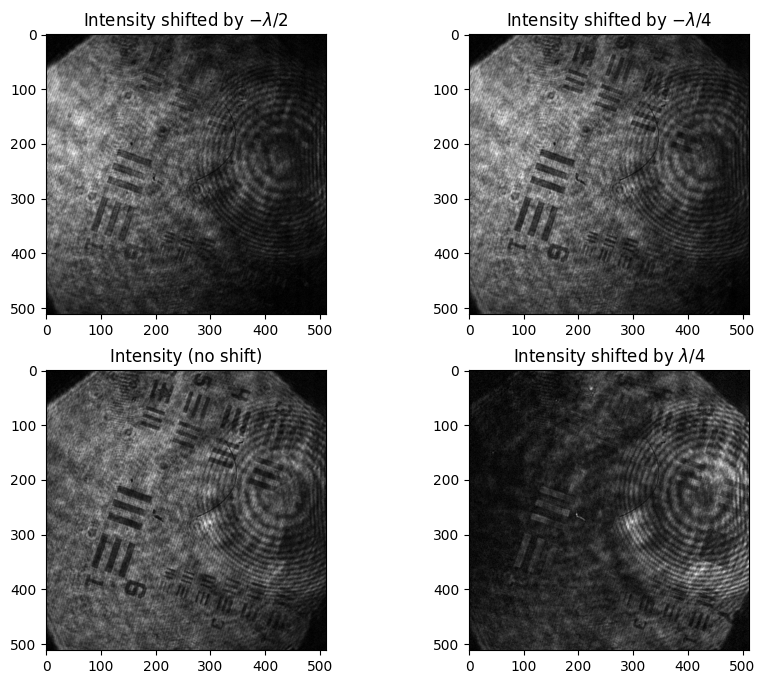

In [5]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(images[0], cmap="gray");
plt.title(r"Intensity shifted by $-\lambda / 2$");
plt.subplot(2, 2, 2)
plt.imshow(images[1], cmap="gray");
plt.title(r"Intensity shifted by $-\lambda / 4$");
plt.subplot(2, 2, 3)
plt.imshow(images[2], cmap="gray");
plt.title(r"Intensity (no shift)");
plt.subplot(2, 2, 4)
plt.imshow(images[3], cmap="gray");
plt.title(r"Intensity shifted by $\lambda / 4$");

Using $E_s(\mathbf{r}) = \frac{1}{4}(I(\mathbf{r}, -\lambda / 2) - I(\mathbf{r}, 0)) + i (I(\mathbf{r}, -\lambda / 4) - I(\mathbf{r}, \lambda / 4) )$, we retrieve the field and display its phase and intensity:

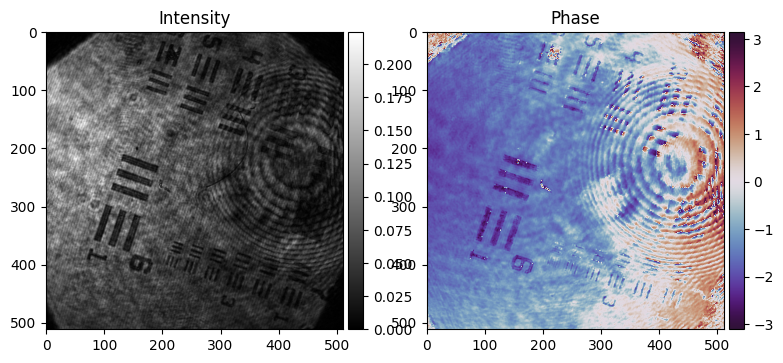

In [6]:
central_field = (images[2] - images[0]) / 4 + 1j * (images[3] - images[1]) / 4

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
ax = axs[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(central_field), cmap='gray');
fig.colorbar(im, cax=cax);
ax.title.set_text(f'Intensity')

ax = axs[1]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.angle(central_field), cmap="twilight_shifted");
fig.colorbar(im, cax=cax);
ax.title.set_text(f'Phase')

## Illumination Compound

In the above, we considered a plane wave with normal incidence, that sheds light on the central components of the Fourier transform of the sample. We thus call this the central illumination, and perform a fast Fourier transform of $E$:

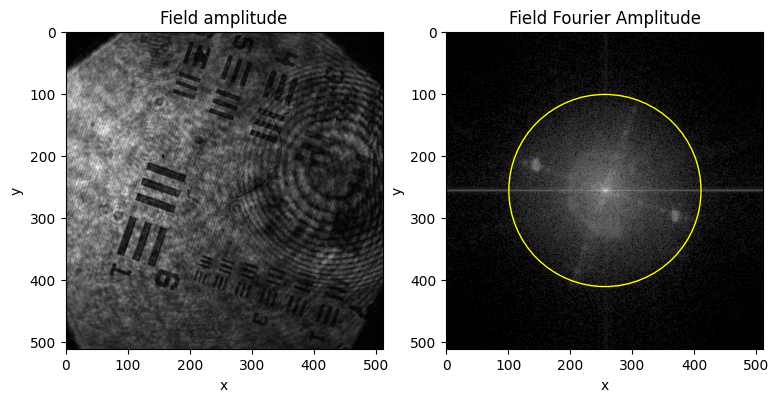

In [7]:
central_field_ft = np.fft.fftshift(np.fft.fft2(central_field))
central_field_ft = central_field_ft / np.max(np.abs(central_field_ft))

_, axs = plt.subplots(1, 2, figsize=(9, 5))
ax = axs[0]
ax.imshow(np.abs(central_field), cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Field amplitude')
ax = axs[1]
ax.imshow(20*np.log10(np.abs(central_field_ft)), vmin=-80, cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Field Fourier Amplitude')

pupil = plt.Circle((nx / 2, nx / 2), nx / 3.3, color='yellow', fill=False);
ax.add_patch(pupil);

Let's now look at another illumination, with non normal incidence and display it's intensity and Fourier transform:

In [8]:
images = []
illu = 3
for i in range(4):
    im = np.array(Image.open(path_to_images / f"Intensity{illu * 4 + i:08}.tif"))
    images.append(im.astype(np.float32) / 255)
    
tilted_field = (images[2] - images[0]) / 4 + 1j * (images[3] - images[1]) / 4

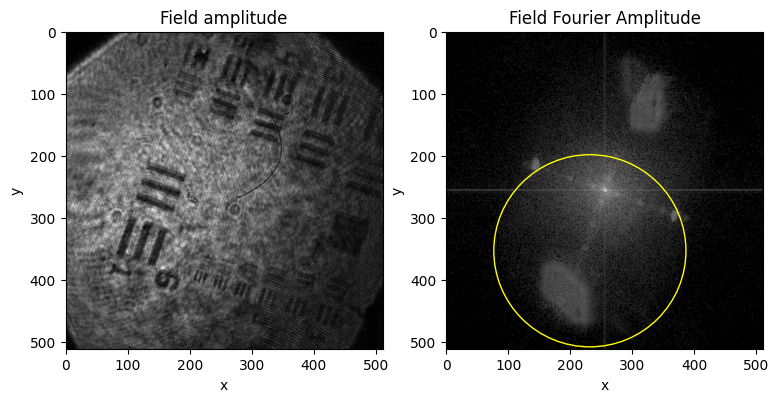

In [9]:
tilted_field_ft = np.fft.fftshift(np.fft.fft2(tilted_field))
tilted_field_ft = tilted_field_ft / np.max(np.abs(tilted_field_ft))


uy, ux = params['uy'][illu], params['ux'][illu]
pupil_factor = 0.6
uy, ux = pupil_factor * uy, pupil_factor * ux

_, axs = plt.subplots(1, 2, figsize=(9, 5))
ax = axs[0]
ax.imshow(np.abs(tilted_field), cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Field amplitude')
ax = axs[1]
ax.imshow(20*np.log10(np.abs(tilted_field_ft)), vmin=-80, cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Field Fourier Amplitude')

pupil = plt.Circle((nx / 2 + ux * nx, nx / 2 - uy * nx), nx / 3.3, color='yellow', fill=False);
ax.add_patch(pupil);

If we combine different illluminations, we obtain an improved resolution. Let's thus load and compute the field for all the illuminations on a grid. We call this the distortion matrix, `dur`

In [10]:
dur = []

for illu in range(params['n_uin']):
    
    images = []


    for i in range(4):
        im = np.array(Image.open(path_to_images / f"Intensity{illu * 4 + i:08}.tif"))
        images.append(im.astype(np.float32) / 255)
    field = (images[2] - images[0]) / 4 + 1j * (images[3] - images[1]) / 4
    
    dur.append(field)

dur = np.stack(dur)

The simplest way to combine these is to sum all the fields. We call this the confocal image.

In [11]:
im_conf = dur.sum(0)

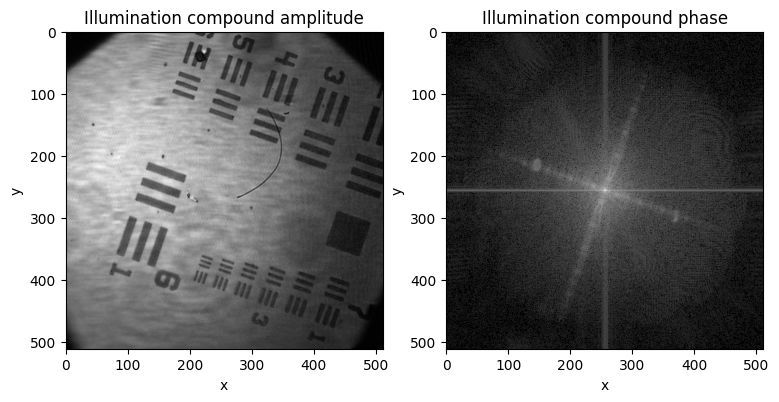

In [12]:
im_conf_ft = np.fft.fftshift(np.fft.fft2(im_conf))
im_conf_ft = im_conf_ft / np.max(np.abs(im_conf_ft))

_, axs = plt.subplots(1, 2, figsize=(9, 5))
ax = axs[0]
ax.imshow(np.abs(im_conf), cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Illumination compound amplitude')
ax = axs[1]
ax.imshow(20*np.log10(np.abs(im_conf_ft)), vmin=-100, cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Illumination compound phase')

But the image is blurred because it was out of focus! Let's make up for this.

## Digital Refocusing

As we have measured the field, we can apply a propagator to virtually move the position of the focal plane. This amounts to computing a phase-shift mask to apply in the Fourier plane. Let $k_x$ and $k_y$ span this plane, i.e. represent the spatial frequencies that are sampled in our image.

Let's come back to a single illumination with normal incidence ot begin. The mask depends on the wave vectors ($k_{z_{out}}$), and the distance between the optical contact and the object ($z$):

$$
\phi(z) = \exp\left( -j k_{z_{out}} z \right)
$$

where $k_{z_{out}} = \sqrt{k_0^2 - k_x ^2 - k_y ^2}$.

In [13]:
name = "Mire_defocused_mifobio"
extension = ".json"
path_to_params = directory / (name + extension)
  
# Opening JSON file
f = open(path_to_params)
params = json.load(f)

path_to_images = directory / "n_mat=0-2"

In [14]:
# Fourier plane coordinates
lambda_c = 840e-9
k0 = 2 * np.pi / lambda_c

n = 1.
dx = 650e-9
dkx = 2 * np.pi / (nx * dx)

bound = (nx - 1) / 2 * dkx
kx = np.linspace(-bound, bound, nx)
ky = np.linspace(bound, -bound, nx)

In [15]:
images = []
illu = (params['n_uin'] - 1) // 2
for i in range(4):
    im = np.array(Image.open(path_to_images / f"Intensity{illu * 4 + i:08}.tif"))
    images.append(im.astype(np.float32) / 255)
central_field = (images[2] - images[0]) / 4 + 1j * (images[3] - images[1]) / 4

In [16]:
k_transverse = kx[None, :]**2 + ky[:, None]**2
kz_out = np.sqrt(np.maximum(0, k0**2 - k_transverse)) # Careful with negative values
pupile = k_transverse < na**2 * k0**2 # Pupil aperture
kz_out = np.where(pupile, kz_out, 0) # Filter phase by pupil aperture

In [17]:
z = -50e-6
fresnel = np.exp(-1j * kz_out * z) * pupile # Filter amplitude by pupil aperture
field_kxky = np.fft.fftshift(np.fft.fft2(central_field))
central_refoc = np.fft.ifft2(field_kxky * fresnel) # Apply the Fresnel mask

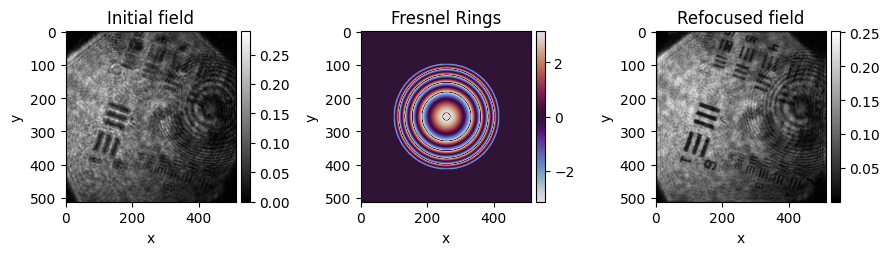

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(9, 5))

ax = axs[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(central_field), aspect='equal', cmap='gray')
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Initial field')

ax = axs[1]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.angle(fresnel), aspect='equal', cmap='twilight')
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Fresnel Rings')

ax = axs[2]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(central_refoc), aspect='equal', cmap='gray')
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Refocused field')

plt.tight_layout()
plt.show()

Ok, now we need to find the right distance $z$, so let's try different values and compare the results. Modify `list_z` to decide the values to test

In [19]:
list_z = np.linspace(-60e-6, -40e-6, 11)
refocs = []
for z in list_z:
    fresnel = np.exp(-1j * kz_out * z)
    field_kxky = np.fft.fftshift(np.fft.fft2(central_field))
    central_refoc = np.fft.ifft2(field_kxky * fresnel)
    refocs.append(np.abs(central_refoc))

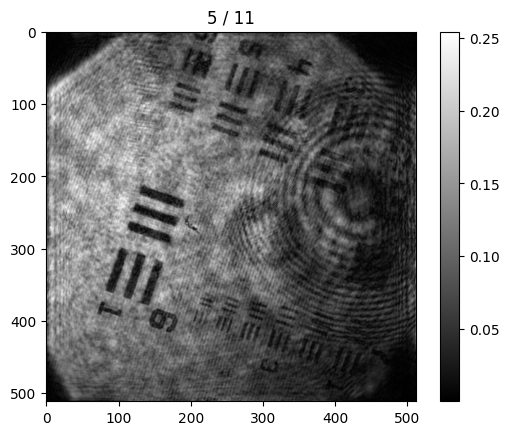

In [20]:
# Press j/k to scroll
multi_slice_viewer(np.stack(refocs, axis=-1), cmap="gray")

In [21]:
# Select the best index from above
z = list_z[5]
print(z)

-5e-05


Let's now look at a different illumination. In this case, we need to account for the incident angle, described in the pupil plane by the couple $(u_x, u_y) \in [-NA, NA]$. At emission we use $k_{z_{in}}$ and at reception $k_{z_{out}}$ becomes:

$$
\begin{align}
k_{z_{in}} &= k_0\sqrt{1 - u_x^2 - u_y^2} \\
k_{z_{out}} &= \sqrt{k_0^2 - (k_x - u_x k_0)^2 - (k_y - u_y k_0)^2}
\end{align}
$$

And the Fresnel mask becomes:

$$
\phi(z) = \exp\left( -j (k_{z_{in}} + k_{z_{out}} ) z \right)
$$

In [22]:
illu = 3

images = []
for i in range(4):
    im = np.array(Image.open(path_to_images / f"Intensity{illu * 4 + i:08}.tif"))
    images.append(im.astype(np.float32) / 255)
tilted_field = (images[2] - images[0]) / 4 + 1j * (images[3] - images[1]) / 4

uy, ux = params['uy'][illu], params['ux'][illu]
pupil_factor = 0.6 # Corrects for the range covered by the mirror at acquisition.
uy, ux = pupil_factor * uy, pupil_factor * ux

kz_in = k0 * np.sqrt(n**2 - ux**2 - uy**2)

k_transverse = (kx[None, :] - k0 * ux)**2 + (ky[:, None] - k0 * uy)**2
kz_out = np.sqrt(np.maximum(0, k0**2 - k_transverse)) # Careful with negative values
pupil = k_transverse < na**2 * k0**2 # Pupil aperture
kz_out = np.where(pupil, kz_out, 0) # Filter by pupil

In [23]:
fresnel = np.exp(-1j * (kz_in + kz_out) * z) * pupil # Filter by pupil
field_kxky = np.fft.fftshift(np.fft.fft2(tilted_field)) # Fourier transform
central_refoc = np.fft.ifft2(field_kxky * fresnel) # Apply mask

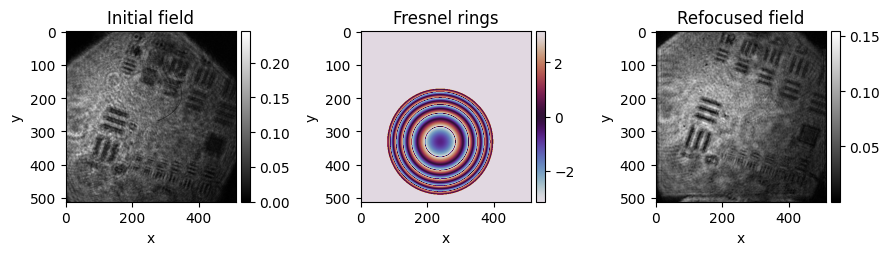

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(9, 5))

ax = axs[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(central_field), aspect='equal', cmap='gray')
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Initial field')

ax = axs[1]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.angle(fresnel), aspect='equal', cmap='twilight')
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Fresnel rings')

ax = axs[2]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(central_refoc), aspect='equal', cmap='gray')
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Refocused field')

plt.tight_layout()
plt.show()

We're now ready to use all the illumination. Each are refocused individually, and then a confocal image is obtained by suming all the refocused illuminations.

In [25]:
dur = []

for illu in range(1, params['n_uin']):
    
    images = []
    
    for i in range(4):
        im = np.array(Image.open(path_to_images / f"Intensity{illu * 4 + i:08}.tif"))
        images.append(im.astype(np.float32) / 255)
    field = (images[2] - images[0]) / 4 + 1j * (images[3] - images[1]) / 4
    
    uy, ux = pupil_factor * params['uy'][illu], pupil_factor * params['ux'][illu]
    kz_in = k0 * np.sqrt(n**2 - ux**2 - uy**2)
    k_transverse = (kx[None, :] - k0 * ux)**2 + (ky[:, None] - k0 * uy)**2
    kz_out = np.sqrt(np.maximum(0, n**2 * k0**2 - k_transverse))
    pupil = k_transverse < na**2 * k0**2
    kz_out = np.where(pupil, kz_out, 0)
    
    fresnel = np.exp(-1j * (kz_in + kz_out) * z) * pupil
    field_kxky = np.fft.fftshift(np.fft.fft2(field))
    refoc = np.fft.ifft2(field_kxky * fresnel)
    dur.append(refoc)

dur = np.stack(dur)

In [26]:
im_conf = dur.sum(0)
im_bulk = np.abs(dur).sum(0)

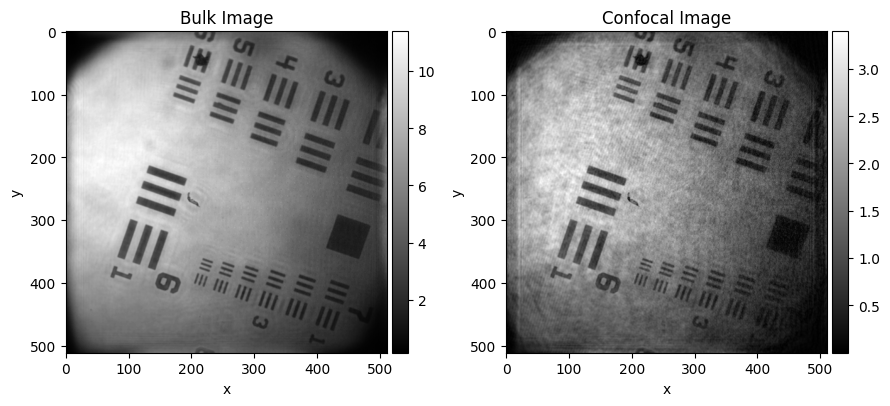

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

ax = axs[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(im_bulk), aspect='equal', cmap="gray")
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Bulk Image')

ax = axs[1]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(np.abs(im_conf), aspect='equal', cmap="gray")
fig.colorbar(im, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.title.set_text(f'Confocal Image')

plt.tight_layout()
plt.show()